In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import time
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
# Import Modules
from keras.models import Sequential,Model
from keras.layers import Input, LSTM, Bidirectional,Dense,Conv1D, Conv2D, MaxPooling1D,MaxPool2D, Flatten, Dropout,TimeDistributed,Multiply
from keras.layers import LeakyReLU,Layer,Input, Reshape, Flatten, Dropout,Conv2D, Reshape, Add, Lambda, Concatenate, Reshape, UpSampling2D
from keras.layers import BatchNormalization, Activation, InputSpec, dot,concatenate
from keras.models import Sequential, Model
import keras.backend as K
from keras.initializers import TruncatedNormal
from keras import optimizers
from keras.layers.core import *
from keras.models import *
from utils import *

In [2]:
shanghai_index = pd.read_excel("SHI.xls")
shanghai_index.rename(columns = {'Shanghai Stock Exchange Composite Index (^000001) - Index Value':'SHI'}, inplace = True)


In [3]:
row_dataset = shanghai_index.set_index('Dates') 
dataset = row_dataset.dropna()

In [4]:
#dataset_diff = np.diff(dataset[['SHI']].values, axis=0)
#dataset_diff.shape

In [5]:
train = dataset[:2000]
train = np.reshape(train,(2000,1))
test = dataset[2000:]
test = np.reshape(test,(431,1))
print(train.shape,test.shape)

(2000, 1) (431, 1)


In [6]:
def construct_X(data, lookback, step):
    X_train_concat = []
    a = (lookback+step)
    for i in range(len(data) - a):
        X_train_concat.append(data[i:(i+lookback)])
    return np.array(X_train_concat)

def construct_Y(data, lookback, step):
    Y_train_concat = []
    for i in range(lookback,(len(data) - step)):
        Y_train_concat.append(data[i:(i+step)])
    return np.array(Y_train_concat)


In [7]:
def con_X(data, lookback, step):
    conx = []
    index = np.arange(0,1779,21)
    for i in index:
        conx.append(data[i:(i+lookback)])
    return np.array(conx)

def con_Y(data, lookback, step):
    cony = []
    index = np.arange(200,1979,21)
    for i in index:
        cony.append(data[i:(i+step)])
    return np.array(cony)

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler1.fit_transform(train)
test_scaled = scaler2.fit_transform(test)
np.allclose(train, scaler1.inverse_transform(train_scaled))
np.allclose(test, scaler2.inverse_transform(test_scaled))
x_train = construct_X(train_scaled,200,21)
y_train = construct_Y(train_scaled,200,21)
x_test = construct_X(test_scaled,200,21)
y_test = construct_Y(test_scaled,200,21)
conx = con_X(train_scaled,200,21)
cony = con_Y(train_scaled,200,21)
##x_train_dataset = x_train.reshape(x_train.shape[0], 21, 1, 1).astype('float32')
#X_train_dataset = tf.data.Dataset.from_tensor_slices((x_train_dataset))
#X_train_dataset = X_train_dataset.batch(64)
#y_train_dataset = y_train.reshape(y_train.shape[0], 21, 1, 1).astype('float32')
#train_dataset_all = tf.data.Dataset.from_tensor_slices((X_train_dataset,y_train_dataset))
#train_dataset_all = train_dataset_all.batch(64)
#train_dataset_all

In [9]:
print(y_train.shape,x_train.shape)
print(conx.shape,cony.shape)

(1779, 21, 1) (1779, 200, 1)
(85, 200, 1) (85, 21, 1)


In [10]:
#expand_dims is used to prepare the dataset for the LSTM model
y_train_no_scale = con_Y(train,200,21)
y_train_no_scaled = np.reshape(y_train_no_scale,(85*21,1))
y_normaliser = MinMaxScaler(feature_range=(0, 1))
#Fit a normaliser such that we can .inverse_fit later on the output
y_normaliser.fit(y_train_no_scaled)

#x_train_no_scale = construct_X(train,200,10)
#x_train_no_scaled = np.reshape(x_train_no_scale,(1790,200))
#x_normaliser = MinMaxScaler(feature_range=(0, 1))
#x_normaliser.fit_transform(x_train_no_scaled)


MinMaxScaler()

In [74]:
adam = optimizers.Adam(lr = 0.005)

/opt/anaconda3/envs/Imperial_Course/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [149]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[0]):
        # calculate mse
        mse = mean_squared_error(actual[i], predicted[i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score

In [274]:
evaluate_forecasts(noscale,pred_noscale)

170.37214560129678

## seq2seq

In [152]:
# seq2seq
def seq2seq1():  
    #Encoder
    encoder_inputs = Input(shape=(200, 1))
    encoder_lstm = LSTM(128, return_sequences=True,return_state=True)
    encoder_outputs, state_hidden, state_cell = encoder_lstm(encoder_inputs)
    encoder_states = [state_hidden, state_cell]
    #Decoder
    decoder_inputs = Input(shape=(21, 1))
    decoder_lstm = LSTM(128, return_sequences=True, return_state=True)
    decoder_outputs, decoder_state_hidden, decoder_state_cell = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(1, activation='linear')
    decoder_outputs = decoder_dense(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    return model

In [153]:
def seq2seq2(): 
    input_train = Input(shape=(200, 1))
    output_train = Input(shape=(21, 1))

    encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(128, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
                                                           return_state=True, return_sequences=True)(input_train)
    encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
    encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)
    
    decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)

    decoder_stack_h = LSTM(128, activation='elu', dropout=0.2, recurrent_dropout=0.2,return_state=False, 
                           return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
    
    attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
    attention = Activation('softmax')(attention)
    
    context = dot([attention, encoder_stack_h], axes=[2,1])
    context = BatchNormalization(momentum=0.6)(context)
    
    decoder_combined_context = concatenate([context, decoder_stack_h])
    
    out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)   

    model = Model(input_train, out)
    return model

In [154]:
def seq2seq3(): 
# define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(200, 1)))
    model.add(RepeatVector(21))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    return model

In [120]:
seq2seq_model = seq2seq()
seq2seq_model.summary()
adam = optimizers.Adam(lr = 0.005)
# Compile 
seq2seq_model.compile(loss='mse',optimizer=adam)
# Train the model 
print('Training model...')
#noise = np.random.normal(0, 1, size=(1969,10, 1))
history = seq2seq_model.fit(x_train,y_train, batch_size=64, epochs=20,validation_split=0.2)
seq2seq_model.save('model_forecasting_seq2seq.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 200)               161600    
                                                                 
 repeat_vector_1 (RepeatVect  (None, 21, 200)          0         
 or)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 21, 200)           320800    
                                                                 
 time_distributed_2 (TimeDis  (None, 21, 100)          20100     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 21, 1)            101       
 tributed)                                                       
                                                      

In [156]:
seq2seq_model1 = seq2seq1()
seq2seq_model1.summary()
adam = optimizers.Adam(lr = 0.005)
# Compile 
seq2seq_model1.compile(loss='mse',optimizer=adam)
# Train the model 
print('Training model...')
noise = np.random.normal(0, 1, size=(1779,21, 1))
history1 = seq2seq_model1.fit([x_train,noise],y_train, batch_size=64, epochs=20,validation_split=0.2)
seq2seq_model.save('model_forecasting_seq2seq.h5')

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 200, 1)]     0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 21, 1)]      0           []                               
                                                                                                  
 lstm_8 (LSTM)                  [(None, 200, 128),   66560       ['input_5[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                            

In [277]:
seq2seq_model2 = seq2seq2()
seq2seq_model2.summary()
adam = optimizers.Adam(lr = 0.005)
# Compile 
seq2seq_model2.compile(loss='mse',optimizer=adam)
# Train the model 
print('Training model...')
history2 = seq2seq_model2.fit(x_train,y_train, batch_size=64, epochs=50,validation_split=0.2)
seq2seq_model2.save('model_forecasting_seq2seq.h5')

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, 200, 1)]     0           []                               
                                                                                                  
 lstm_14 (LSTM)                 [(None, 200, 128),   66560       ['input_34[0][0]']               
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 128)         512         ['lstm_14[0][1]']                
 rmalization)                                                                              

Epoch 42/50
23/23 [==============================] - 6s 266ms/step - loss: 0.0043 - val_loss: 0.0017
Epoch 43/50
23/23 [==============================] - 6s 264ms/step - loss: 0.0042 - val_loss: 0.0016
Epoch 44/50
23/23 [==============================] - 6s 264ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 45/50
23/23 [==============================] - 6s 267ms/step - loss: 0.0044 - val_loss: 0.0020
Epoch 46/50
23/23 [==============================] - 6s 268ms/step - loss: 0.0042 - val_loss: 0.0016
Epoch 47/50
23/23 [==============================] - 6s 273ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 48/50
23/23 [==============================] - 6s 263ms/step - loss: 0.0039 - val_loss: 0.0025
Epoch 49/50
23/23 [==============================] - 6s 265ms/step - loss: 0.0040 - val_loss: 0.0021
Epoch 50/50
23/23 [==============================] - 6s 270ms/step - loss: 0.0044 - val_loss: 0.0015


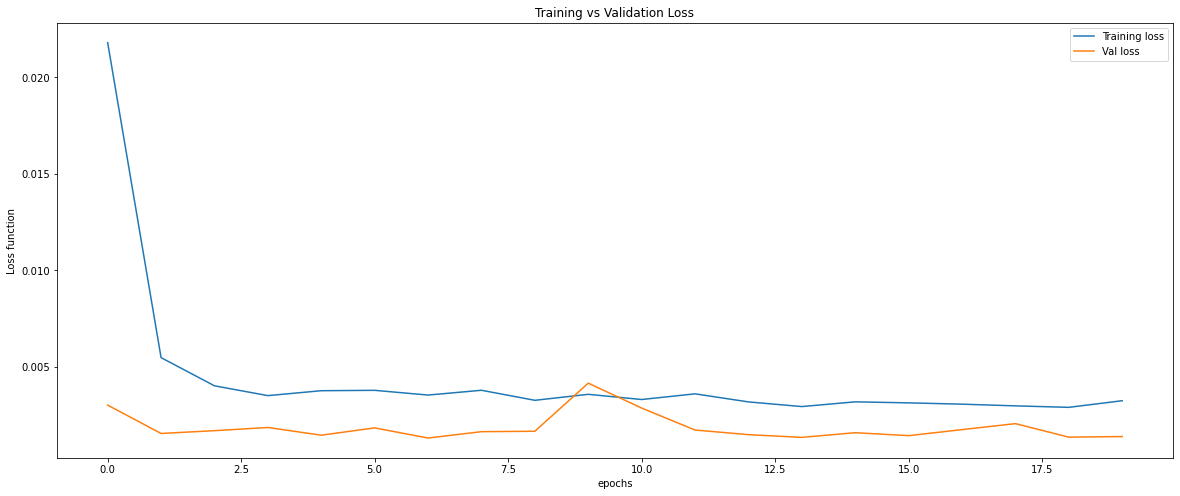

In [121]:
fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(history.history["loss"], label = "Training loss")
plt.plot(history.history["val_loss"], label = "Val loss")
plt.xlabel("epochs")
plt.ylabel("Loss function")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

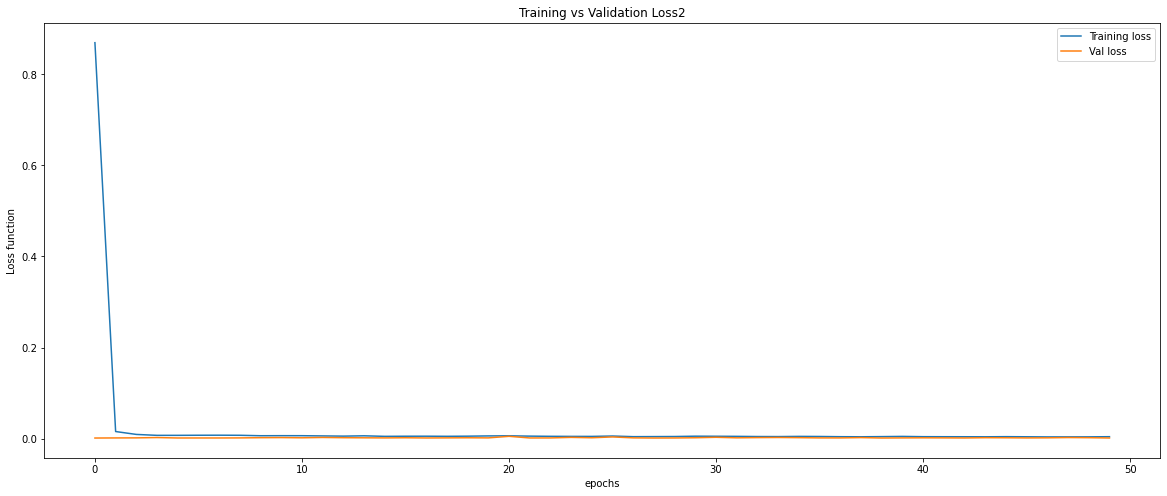

In [278]:
fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(history2.history["loss"], label = "Training loss")
plt.plot(history2.history["val_loss"], label = "Val loss")
plt.xlabel("epochs")
plt.ylabel("Loss function")
plt.title("Training vs Validation Loss2")
plt.legend()
plt.show()

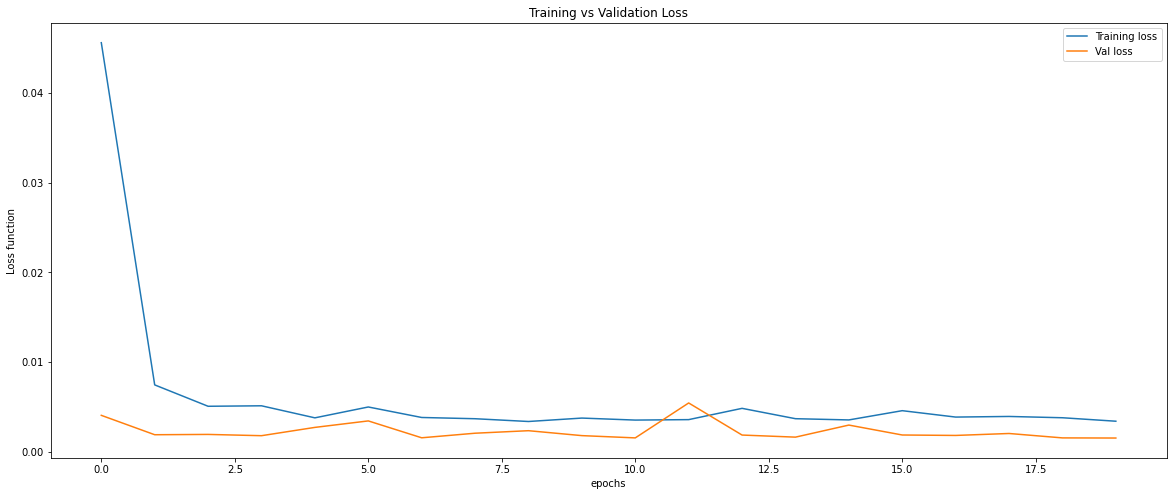

In [157]:
fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(history1.history["loss"], label = "Training loss")
plt.plot(history1.history["val_loss"], label = "Val loss")
plt.xlabel("epochs")
plt.ylabel("Loss function")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [134]:
pred_train_seq = seq2seq_model.predict(conx)
#pred_test_seq = seq2seq_model.predict([x_test,noise2])
#pred_test_seq = np.reshape(pred_test_seq,(pred_test_seq.shape[0],3))
#rmse_seq = sqrt(mean_squared_error(y_test, pred_test_seq))
#print(rmse_seq)
y_train_pred = np.reshape(pred_train_seq,(85*21,1))
y_train_plot = np.reshape(cony,(85*21,1))
pred_noscale = y_normaliser.inverse_transform(y_train_pred)
noscale = y_normaliser.inverse_transform(y_train_plot)


3/3 [==============================] - 0s 61ms/step


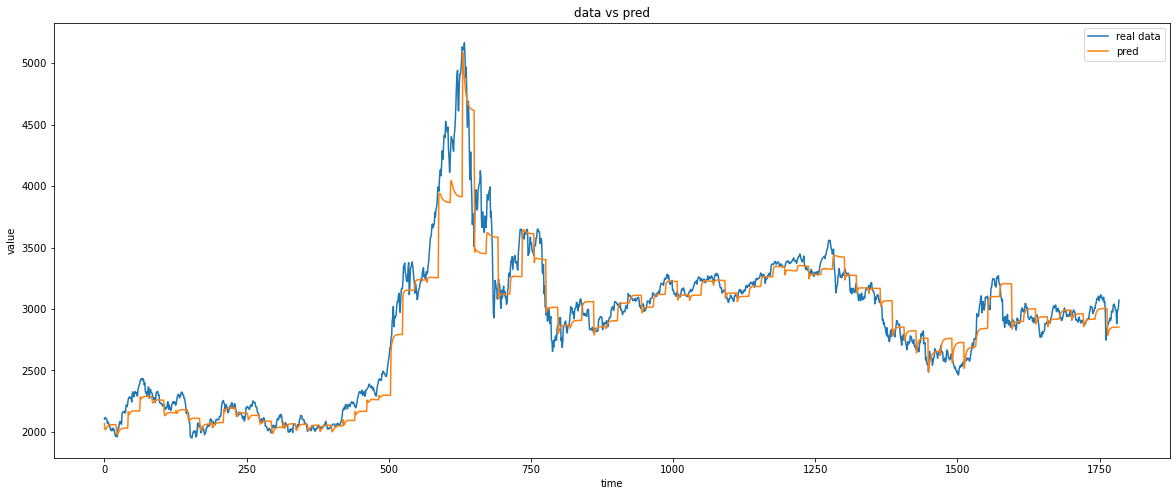

In [135]:
y_train_pred = np.reshape(pred_train_seq,(85*21,1))
y_train_plot = np.reshape(cony,(85*21,1))
fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(noscale, label = "real data")
plt.plot(pred_noscale, label = "pred")

plt.xlabel("time")
plt.ylabel("value")
plt.title("data vs pred")
plt.legend()
plt.show()

In [151]:
evaluate_forecasts(noscale,pred_noscale)

170.37214560129678

In [280]:
pred_train_seq2 = seq2seq_model2.predict(conx)
#pred_test_seq = seq2seq_model.predict([x_test,noise2])
#pred_test_seq = np.reshape(pred_test_seq,(pred_test_seq.shape[0],3))
#rmse_seq = sqrt(mean_squared_error(y_test, pred_test_seq))
#print(rmse_seq)
y_train_pred2 = np.reshape(pred_train_seq2,(85*21,1))
pred_noscale2 = y_normaliser.inverse_transform(y_train_pred2)
noscale2 = y_normaliser.inverse_transform(y_train_plot)

3/3 [==============================] - 0s 43ms/step


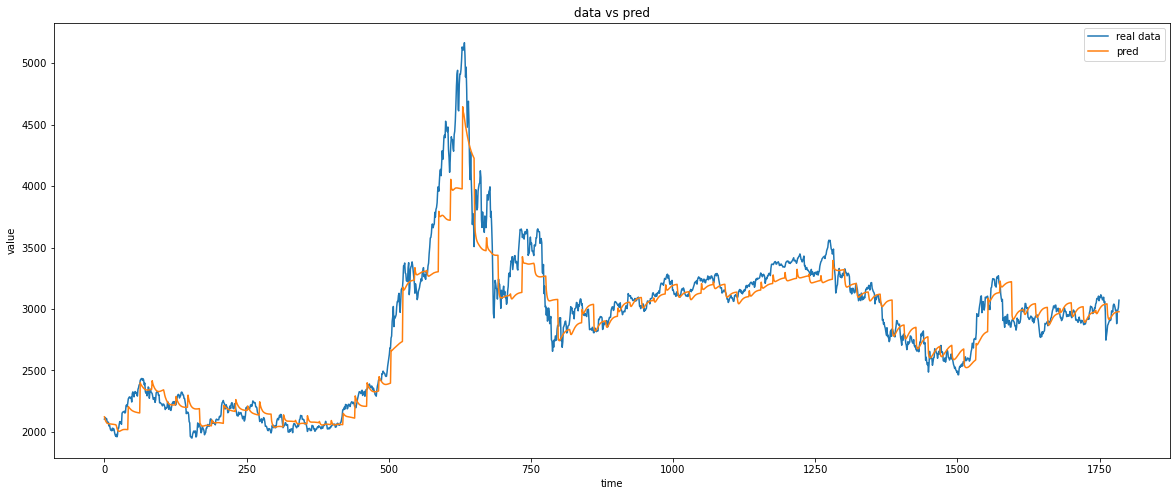

In [282]:
y_train_pred2 = np.reshape(pred_train_seq2,(85*21,1))
fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(noscale, label = "real data")
plt.plot(pred_noscale2, label = "pred")

plt.xlabel("time")
plt.ylabel("value")
plt.title("data vs pred")
plt.legend()
plt.show()

In [283]:
evaluate_forecasts(noscale1,pred_noscale2)

175.2539215914823

In [159]:
noise1 = np.random.normal(0, 1, size=(85,21, 1))
pred_train_seq1 = seq2seq_model1.predict([conx,noise1])
#pred_test_seq = seq2seq_model.predict([x_test,noise2])
#pred_test_seq = np.reshape(pred_test_seq,(pred_test_seq.shape[0],3))
#rmse_seq = sqrt(mean_squared_error(y_test, pred_test_seq))
#print(rmse_seq)
y_train_pred1 = np.reshape(pred_train_seq1,(85*21,1))
y_train_plot1 = np.reshape(cony,(85*21,1))
pred_noscale1 = y_normaliser.inverse_transform(y_train_pred1)
noscale1 = y_normaliser.inverse_transform(y_train_plot1)


3/3 [==============================] - 1s 30ms/step


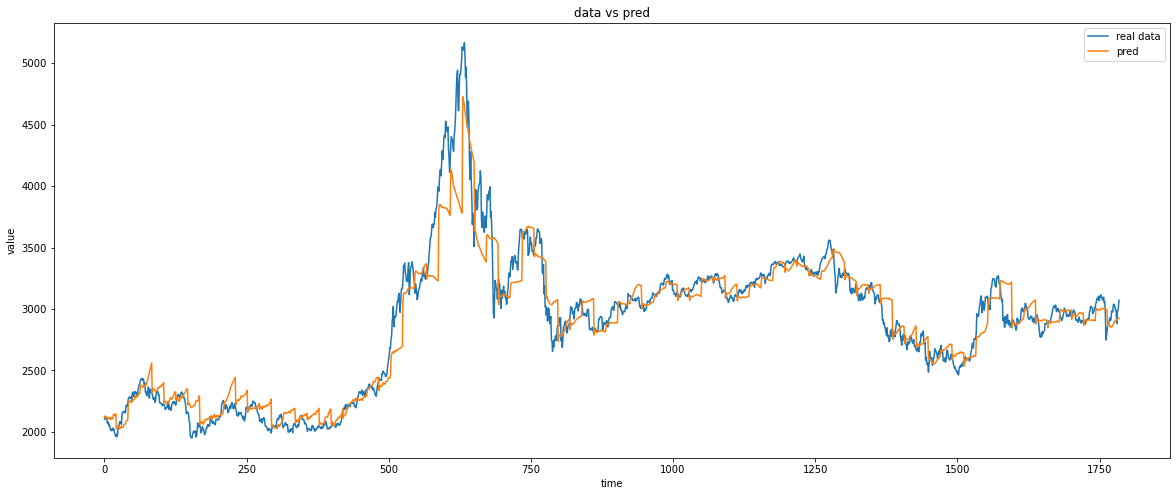

In [160]:
fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(noscale1, label = "real data")
plt.plot(pred_noscale1, label = "pred")

plt.xlabel("time")
plt.ylabel("value")
plt.title("data vs pred")
plt.legend()
plt.show()

In [161]:
evaluate_forecasts(noscale1,pred_noscale1)

174.62532472052558

## BUY-SELL

In [ ]:
def buy_sell_trades(noscale, pred_noscale):
    pred_df = pd.DataFrame()
    pred_df['Predictions'] = pred_noscale


    y_pct_change = pred_df.pct_change()

    money = 1000000
    number_of_stocks = (int)(10000 / noscale[0])
    left = 10000 - (int)(10000 / noscale[0]) * noscale[0] + noscale[len(noscale) - 1] * number_of_stocks

    number_of_stocks = 0

    buying_percentage_threshold = 0.0015 #as long as we have a 0.15% increase/decrease we buy/sell the stock
    selling_percentage_threshold = 0.0015

    for i in range(len(noscale) - 1):    
        if y_pct_change['Predictions'][i + 1] > buying_percentage_threshold:
            for j in range(100, 0, -1):
                #Buying of stock
                if (money >= 100 * noscale[i]):
                    money -= 100 * noscale[i]
                    number_of_stocks += 100
                    break
        elif  y_pct_change['Predictions'][i + 1] < -selling_percentage_threshold:
            for j in range(100, 0, -1):
                #Selling of stock
                if (number_of_stocks >= j):
                    money += j * noscale[i]
                    number_of_stocks -= j
                    break

    money += number_of_stocks * noscale[len(noscale) - 1]

    print(money) #Money if we traded
    print(left)  #Money if we just bought as much at the start and sold near the end (Buy and hold)

    return y_pct_change


## GAN+Attention

In [4]:
def generator(latent_dim,ntimes,ninput):
    model = tf.keras.Sequential()
#     init = RandomNormal(stddev=0.02)
#     init = tf.initializers.RandomNormal(stddev=0.02)


    # BiLSTM generator
#     in_gen = Input(shape=(latent_dim,))
#     x = Dense(ntimes*ninput)(in_gen)
#     x = Reshape((ntimes, ninput))(x)
    in_gen = Input(shape=(ntimes, ninput))

    lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=False))(in_gen)
    dp_1 = Dropout(0.2)(lstm_1)
    bn_1 = tf.keras.layers.LayerNormalization()(dp_1)
    rv_1 = tf.keras.layers.RepeatVector(1)(bn_1)
    # BiLSTM generator output
    gen_output = tf.keras.layers.TimeDistributed(Dense(ninput, activation='linear'))(rv_1)

    alstm = Model(in_gen, gen_output)
    return alstm

In [5]:
generator = generator(100,ntimes=100, ninput=1)
generator.summary()

2022-08-15 22:51:42.770665: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 1)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 256)              133120    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 layer_normalization (LayerN  (None, 256)              512       
 ormalization)                                                   
                                                                 
 repeat_vector (RepeatVector  (None, 1, 256)           0         
 )                                                               
                                                             

In [6]:
def make_discriminator_model(ntimes,ninput):   
    model = tf.keras.Sequential()
    #const = ClipConstraint(0.01)
    
    # Discriminator is a bidirectional LSTM with input latent dimensions and output dim = 1
    in_disc = Input(shape=(1, ninput))
    lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=False))(in_disc)
    dp_1 = Dropout(0.2)(lstm_1)
    bn_1 = tf.keras.layers.LayerNormalization()(dp_1)
    rv_1 = tf.keras.layers.RepeatVector(1)(bn_1)

    # Discriminator output
    disc_output = tf.keras.layers.TimeDistributed(Dense(1, activation='linear'))(rv_1)
    discriminator = Model(in_disc, disc_output)

    return  discriminator




In [7]:
discriminator = make_discriminator_model(ntimes=100,ninput=1)
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 1)]            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              133120    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 layer_normalization_1 (Laye  (None, 256)              512       
 rNormalization)                                                 
                                                                 
 repeat_vector_1 (RepeatVect  (None, 1, 256)           0         
 or)                                                             
                                                           

In [8]:
# We will reuse this seed overtime 
latent_space=100
num_examples_to_generate = 5
seed = tf.random.normal([num_examples_to_generate, latent_space])

In [59]:
def train(X_all,y_all, epochs):
    hist = []
    real = np.ones(16)
    fake = np.zeros(16)
    c1_hist = []
    c2_hist = []
    
    for epoch in range(epochs):
        start = time.time()
        print("Epoch {}/{}".format(epoch + 1, epochs))
        c1_tmp, c2_tmp = list(), list()

        for i in range(16):
            # Randomly selected samples and noise
            randomIndex = np.random.randint(0, X_all.shape[0], size=16)
            noise = np.random.normal(0, 1, size=(16, 100, 1))
            # Select a random batch for input
            real_input = X_all[randomIndex]
            real_output = y_all[randomIndex]

            # Generate a batch of new outputs (in the latent space) predicted by the generator
            alstm_seqs = generator.predict(noise)

            # Train the discriminator
            # The arbitrary noise is considered to be a "real" sample
            d_loss_real = discriminator.train_on_batch(real_output, real)
            c1_tmp.append(d_loss_real)
            # The latent space generated by the encoder is considered a "fake" sample
            d_loss_fake = discriminator.train_on_batch(alstm_seqs, fake)
            c2_tmp.append(d_loss_fake)
            
        
            
#         with generator_summary_writer.as_default():
#             tf.summary.scalar('loss', generator_mean_loss.result(), step=epoch)

#         with discriminator_summary_writer.as_default():
#             tf.summary.scalar('loss', discriminator_mean_loss.result(), step=epoch)
        c1_hist.append(np.mean(c1_tmp))
        c2_hist.append(np.mean(c2_tmp))
        g_loss = combined.train_on_batch(real_input, [real_output, real])
        hist.append(g_loss)
        
        print("%d [C1 real: %f, C2 fake: %f], [G loss: %f, mse: %f]" % (epoch, c1_hist[epoch],
                                                                            c2_hist[epoch],
                                                                            g_loss[0],
                                                                            g_loss[1]
                                                                            ))


#         generator_mean_loss.reset_states()
#         discriminator_mean_loss.reset_states()
        
#         print("discriminator", "{}: {:.6f}".format(discriminator, hist[-1][1]), end=' - ')
#         print("generator", "{}: {:.6f}".format(gan, hist[-1][0]), end=' - ')    
#         print ('{:.0f}s'.format( time.time()-start))

#         # Global variables are used below
#         if epoch%100== 0: 
#             # plot loss
#             print('Loss: ')
#             fig, ax = plt.subplots(1,1, figsize=[20,10])
#             ax.plot(hist)
#             ax.legend(['loss_gen', 'loss_disc'])
#             ax.set_yscale('log')
#             ax.grid()
#             plt.show()
            
    return hist

In [10]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
discriminator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [11]:
discriminator.compile(loss='binary_crossentropy', optimizer='Adam')
generator.compile(loss='binary_crossentropy', optimizer='Adam')

In [12]:
real_input = Input(shape=(100, 1))
fake_output = generator(real_input)
discriminator_output = discriminator(fake_output)
combined = Model(real_input, [fake_output, discriminator_output])
combined.compile(loss=['mse', 'binary_crossentropy'], loss_weights=[0.999, 0.001], optimizer='Adam')

In [13]:
combined.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 1)]          0         
                                                                 
 model (Functional)          (None, 1, 1)              133889    
                                                                 
 model_1 (Functional)        (None, 1, 1)              133889    
                                                                 
Total params: 267,778
Trainable params: 267,778
Non-trainable params: 0
_________________________________________________________________


In [63]:
hist = train(X_all,y_all,epochs=200) 

Epoch 1/200
1/1 [==============================] - 0s 31ms/step
0 [C1 real: 1.036568, C2 fake: 1.839098], [G loss: 0.233552, mse: 0.230946]
Epoch 2/200
1/1 [==============================] - 0s 33ms/step
1 [C1 real: 0.417970, C2 fake: 1.898594], [G loss: 3.235771, mse: 3.227141]
Epoch 3/200
1/1 [==============================] - 0s 28ms/step
2 [C1 real: 0.427708, C2 fake: 1.547541], [G loss: 0.298065, mse: 0.297341]
Epoch 4/200
1/1 [==============================] - 0s 29ms/step
3 [C1 real: 1.496170, C2 fake: 0.825412], [G loss: 0.711724, mse: 0.711749]
Epoch 5/200
1/1 [==============================] - 0s 31ms/step
4 [C1 real: 1.415823, C2 fake: 4.951747], [G loss: 0.989740, mse: 0.990635]
Epoch 6/200
1/1 [==============================] - 0s 32ms/step
5 [C1 real: 0.971571, C2 fake: 3.866289], [G loss: 1.029573, mse: 1.030135]
Epoch 7/200
1/1 [==============================] - 0s 30ms/step
6 [C1 real: 1.043081, C2 fake: 0.474022], [G loss: 0.292433, mse: 0.291479]
Epoch 8/200
1/1 [===

1/1 [==============================] - 0s 31ms/step
17 [C1 real: 0.425976, C2 fake: 1.114719], [G loss: 0.244622, mse: 0.243778]
Epoch 19/200
1/1 [==============================] - 0s 29ms/step
18 [C1 real: 0.417884, C2 fake: 1.067268], [G loss: 0.066630, mse: 0.065968]
Epoch 20/200
1/1 [==============================] - 0s 28ms/step
19 [C1 real: 0.773395, C2 fake: 0.721813], [G loss: 0.080002, mse: 0.078765]
Epoch 21/200
1/1 [==============================] - 0s 27ms/step
20 [C1 real: 0.732027, C2 fake: 0.587534], [G loss: 0.073800, mse: 0.073125]
Epoch 22/200
1/1 [==============================] - 0s 25ms/step
21 [C1 real: 0.533576, C2 fake: 0.788354], [G loss: 0.122042, mse: 0.121421]
Epoch 23/200
1/1 [==============================] - 0s 28ms/step
22 [C1 real: 0.470867, C2 fake: 0.903040], [G loss: 0.198900, mse: 0.197435]
Epoch 24/200
1/1 [==============================] - 0s 27ms/step
23 [C1 real: 0.450399, C2 fake: 0.930919], [G loss: 0.093354, mse: 0.092891]
Epoch 25/200
1/1 [=

1/1 [==============================] - 0s 28ms/step
26 [C1 real: 0.605749, C2 fake: 0.739834], [G loss: 0.075301, mse: 0.074692]
Epoch 28/200
1/1 [==============================] - 0s 28ms/step
27 [C1 real: 0.543013, C2 fake: 0.816994], [G loss: 0.079922, mse: 0.079249]
Epoch 29/200
1/1 [==============================] - 0s 33ms/step
28 [C1 real: 0.508240, C2 fake: 0.825400], [G loss: 0.042189, mse: 0.041544]
Epoch 30/200
1/1 [==============================] - 0s 32ms/step
29 [C1 real: 0.720798, C2 fake: 0.602787], [G loss: 0.036114, mse: 0.034358]
Epoch 31/200
1/1 [==============================] - 0s 30ms/step
30 [C1 real: 0.639214, C2 fake: 0.676083], [G loss: 0.114134, mse: 0.113299]
Epoch 32/200
1/1 [==============================] - 0s 30ms/step
31 [C1 real: 0.606880, C2 fake: 0.697284], [G loss: 0.154771, mse: 0.153959]
Epoch 33/200
1/1 [==============================] - 0s 31ms/step
32 [C1 real: 0.517200, C2 fake: 0.758326], [G loss: 0.100782, mse: 0.100362]
Epoch 34/200
1/1 [=

1/1 [==============================] - 0s 30ms/step
35 [C1 real: 0.505740, C2 fake: 0.774992], [G loss: 0.091731, mse: 0.091059]
Epoch 37/200
1/1 [==============================] - 0s 30ms/step
36 [C1 real: 0.516024, C2 fake: 0.767958], [G loss: 0.113106, mse: 0.112393]
Epoch 38/200
1/1 [==============================] - 0s 33ms/step
37 [C1 real: 0.531960, C2 fake: 0.748047], [G loss: 0.057361, mse: 0.056617]
Epoch 39/200
1/1 [==============================] - 0s 27ms/step
38 [C1 real: 0.556769, C2 fake: 0.763002], [G loss: 0.135167, mse: 0.134553]
Epoch 40/200
1/1 [==============================] - 0s 27ms/step
39 [C1 real: 0.539520, C2 fake: 0.789469], [G loss: 0.078023, mse: 0.077404]
Epoch 41/200
1/1 [==============================] - 0s 27ms/step
40 [C1 real: 0.540646, C2 fake: 0.732050], [G loss: 0.089891, mse: 0.089093]
Epoch 42/200
1/1 [==============================] - 0s 27ms/step
41 [C1 real: 0.518235, C2 fake: 0.767947], [G loss: 0.073243, mse: 0.072642]
Epoch 43/200
1/1 [=

1/1 [==============================] - 0s 26ms/step
44 [C1 real: 0.556263, C2 fake: 0.736738], [G loss: 0.075696, mse: 0.075005]
Epoch 46/200
1/1 [==============================] - 0s 26ms/step
45 [C1 real: 0.548594, C2 fake: 0.765597], [G loss: 0.185728, mse: 0.183315]
Epoch 47/200
1/1 [==============================] - 0s 33ms/step
46 [C1 real: 0.555343, C2 fake: 0.701627], [G loss: 0.024229, mse: 0.023554]
Epoch 48/200
1/1 [==============================] - 0s 26ms/step
47 [C1 real: 0.542945, C2 fake: 0.702884], [G loss: 0.121525, mse: 0.120918]
Epoch 49/200
1/1 [==============================] - 0s 27ms/step
48 [C1 real: 0.520465, C2 fake: 0.731650], [G loss: 0.065812, mse: 0.065226]
Epoch 50/200
1/1 [==============================] - 0s 26ms/step
49 [C1 real: 0.541872, C2 fake: 0.719093], [G loss: 0.058960, mse: 0.058295]
Epoch 51/200
1/1 [==============================] - 0s 28ms/step
50 [C1 real: 0.540238, C2 fake: 0.776780], [G loss: 0.061199, mse: 0.060552]
Epoch 52/200
1/1 [=

1/1 [==============================] - 0s 27ms/step
53 [C1 real: 0.533146, C2 fake: 0.739045], [G loss: 0.179019, mse: 0.176571]
Epoch 55/200
1/1 [==============================] - 0s 26ms/step
54 [C1 real: 0.589136, C2 fake: 0.657160], [G loss: 0.069266, mse: 0.068383]
Epoch 56/200
1/1 [==============================] - 0s 27ms/step
55 [C1 real: 0.543136, C2 fake: 0.727538], [G loss: 0.047609, mse: 0.046873]
Epoch 57/200
1/1 [==============================] - 0s 29ms/step
56 [C1 real: 0.543444, C2 fake: 0.720682], [G loss: 0.051234, mse: 0.050520]
Epoch 58/200
1/1 [==============================] - 0s 27ms/step
57 [C1 real: 0.541474, C2 fake: 0.685076], [G loss: 0.069301, mse: 0.068766]
Epoch 59/200
1/1 [==============================] - 0s 27ms/step
58 [C1 real: 0.515802, C2 fake: 0.694578], [G loss: 0.032975, mse: 0.032294]
Epoch 60/200
1/1 [==============================] - 0s 28ms/step
59 [C1 real: 0.553330, C2 fake: 0.624866], [G loss: 0.052983, mse: 0.052290]
Epoch 61/200
1/1 [=

1/1 [==============================] - 0s 27ms/step
62 [C1 real: 0.520111, C2 fake: 0.676820], [G loss: 0.050300, mse: 0.049643]
Epoch 64/200
1/1 [==============================] - 0s 26ms/step
63 [C1 real: 0.528226, C2 fake: 0.678555], [G loss: 0.074512, mse: 0.073630]
Epoch 65/200
1/1 [==============================] - 0s 27ms/step
64 [C1 real: 0.475082, C2 fake: 0.603089], [G loss: 0.227610, mse: 0.223331]
Epoch 66/200
1/1 [==============================] - 0s 28ms/step
65 [C1 real: 0.472290, C2 fake: 0.672172], [G loss: 0.139968, mse: 0.136256]
Epoch 67/200
1/1 [==============================] - 0s 29ms/step
66 [C1 real: 0.460578, C2 fake: 0.742305], [G loss: 0.123359, mse: 0.120854]
Epoch 68/200
1/1 [==============================] - 0s 29ms/step
67 [C1 real: 0.580327, C2 fake: 0.574763], [G loss: 0.011104, mse: 0.010274]
Epoch 69/200
1/1 [==============================] - 0s 29ms/step
68 [C1 real: 0.533726, C2 fake: 0.628040], [G loss: 0.071948, mse: 0.071196]
Epoch 70/200
1/1 [=

1/1 [==============================] - 0s 30ms/step
71 [C1 real: 0.475324, C2 fake: 0.618864], [G loss: 0.066752, mse: 0.065995]
Epoch 73/200
1/1 [==============================] - 0s 30ms/step
72 [C1 real: 0.611022, C2 fake: 0.529311], [G loss: 0.069726, mse: 0.068947]
Epoch 74/200
1/1 [==============================] - 0s 28ms/step
73 [C1 real: 0.490723, C2 fake: 0.697188], [G loss: 0.055173, mse: 0.054320]
Epoch 75/200
1/1 [==============================] - 0s 29ms/step
74 [C1 real: 0.501730, C2 fake: 0.617005], [G loss: 0.068070, mse: 0.067390]
Epoch 76/200
1/1 [==============================] - 0s 28ms/step
75 [C1 real: 0.444432, C2 fake: 0.597950], [G loss: 0.186985, mse: 0.183635]
Epoch 77/200
1/1 [==============================] - 0s 29ms/step
76 [C1 real: 0.480172, C2 fake: 0.568216], [G loss: 0.106376, mse: 0.102806]
Epoch 78/200
1/1 [==============================] - 0s 27ms/step
77 [C1 real: 0.468564, C2 fake: 0.664705], [G loss: 0.070333, mse: 0.066862]
Epoch 79/200
1/1 [=

1/1 [==============================] - 0s 28ms/step
80 [C1 real: 0.441932, C2 fake: 0.557855], [G loss: 0.085060, mse: 0.084300]
Epoch 82/200
1/1 [==============================] - 0s 30ms/step
81 [C1 real: 0.459133, C2 fake: 0.569765], [G loss: 0.041065, mse: 0.039267]
Epoch 83/200
1/1 [==============================] - 0s 29ms/step
82 [C1 real: 0.451626, C2 fake: 0.537037], [G loss: 0.053221, mse: 0.051650]
Epoch 84/200
1/1 [==============================] - 0s 28ms/step
83 [C1 real: 0.561324, C2 fake: 0.574098], [G loss: 0.024239, mse: 0.023411]
Epoch 85/200
1/1 [==============================] - 0s 31ms/step
84 [C1 real: 0.859122, C2 fake: 0.467173], [G loss: 0.075478, mse: 0.070817]
Epoch 86/200
1/1 [==============================] - 0s 31ms/step
85 [C1 real: 0.450515, C2 fake: 0.933248], [G loss: 0.042037, mse: 0.041495]
Epoch 87/200
1/1 [==============================] - 0s 29ms/step
86 [C1 real: 0.514773, C2 fake: 0.600299], [G loss: 0.070104, mse: 0.067569]
Epoch 88/200
1/1 [=

1/1 [==============================] - 0s 30ms/step
97 [C1 real: 0.566678, C2 fake: 0.486008], [G loss: 0.058626, mse: 0.057094]
Epoch 99/200
1/1 [==============================] - 0s 30ms/step
98 [C1 real: 0.367767, C2 fake: 0.748559], [G loss: 0.036855, mse: 0.036256]
Epoch 100/200
1/1 [==============================] - 0s 30ms/step
99 [C1 real: 0.434884, C2 fake: 0.536405], [G loss: 0.032052, mse: 0.031485]
Epoch 101/200
1/1 [==============================] - 0s 28ms/step
100 [C1 real: 0.394416, C2 fake: 0.626069], [G loss: 0.009971, mse: 0.009357]
Epoch 102/200
1/1 [==============================] - 0s 28ms/step
101 [C1 real: 0.375063, C2 fake: 0.577445], [G loss: 0.041760, mse: 0.040148]
Epoch 103/200
1/1 [==============================] - 0s 27ms/step
102 [C1 real: 0.364120, C2 fake: 0.518140], [G loss: 0.053036, mse: 0.051349]
Epoch 104/200
1/1 [==============================] - 0s 27ms/step
103 [C1 real: 0.378997, C2 fake: 0.573000], [G loss: 0.017007, mse: 0.016370]
Epoch 105/

1/1 [==============================] - 0s 27ms/step
115 [C1 real: 0.334959, C2 fake: 0.497670], [G loss: 0.023577, mse: 0.022703]
Epoch 117/200
1/1 [==============================] - 0s 29ms/step
116 [C1 real: 0.353731, C2 fake: 0.497789], [G loss: 0.027220, mse: 0.023714]
Epoch 118/200
1/1 [==============================] - 0s 33ms/step
117 [C1 real: 0.384745, C2 fake: 0.535453], [G loss: 0.026431, mse: 0.024825]
Epoch 119/200
1/1 [==============================] - 0s 29ms/step
118 [C1 real: 0.386697, C2 fake: 0.488870], [G loss: 0.050230, mse: 0.046835]
Epoch 120/200
1/1 [==============================] - 0s 30ms/step
119 [C1 real: 0.367399, C2 fake: 0.587475], [G loss: 0.024529, mse: 0.023784]
Epoch 121/200
1/1 [==============================] - 0s 28ms/step
120 [C1 real: 0.384922, C2 fake: 0.621274], [G loss: 0.066939, mse: 0.063478]
Epoch 122/200
1/1 [==============================] - 0s 30ms/step
121 [C1 real: 0.361024, C2 fake: 0.580940], [G loss: 0.055612, mse: 0.051477]
Epoch 

1/1 [==============================] - 0s 40ms/step
133 [C1 real: 0.326713, C2 fake: 0.512619], [G loss: 0.043547, mse: 0.040234]
Epoch 135/200
1/1 [==============================] - 0s 34ms/step
134 [C1 real: 0.353607, C2 fake: 0.508499], [G loss: 0.015206, mse: 0.014669]
Epoch 136/200
1/1 [==============================] - 0s 37ms/step
135 [C1 real: 0.335666, C2 fake: 0.580835], [G loss: 0.034072, mse: 0.031388]
Epoch 137/200
1/1 [==============================] - 0s 36ms/step
136 [C1 real: 0.344852, C2 fake: 0.551631], [G loss: 0.037722, mse: 0.035207]
Epoch 138/200
1/1 [==============================] - 0s 44ms/step
137 [C1 real: 0.379064, C2 fake: 0.413266], [G loss: 0.024697, mse: 0.022363]
Epoch 139/200
1/1 [==============================] - 0s 85ms/step
138 [C1 real: 0.353852, C2 fake: 0.444297], [G loss: 0.068382, mse: 0.064832]
Epoch 140/200
1/1 [==============================] - 0s 64ms/step
139 [C1 real: 0.319833, C2 fake: 0.646751], [G loss: 0.036852, mse: 0.033228]
Epoch 

1/1 [==============================] - 0s 36ms/step
142 [C1 real: 15.424949, C2 fake: 0.001165], [G loss: 0.110436, mse: 0.095107]
Epoch 144/200
1/1 [==============================] - 0s 35ms/step
143 [C1 real: 15.424949, C2 fake: 0.003144], [G loss: 0.057991, mse: 0.042609]
Epoch 145/200
1/1 [==============================] - 0s 41ms/step
144 [C1 real: 15.424949, C2 fake: 0.002587], [G loss: 0.031082, mse: 0.015673]
Epoch 146/200
1/1 [==============================] - 0s 39ms/step
145 [C1 real: 15.424949, C2 fake: 0.002656], [G loss: 0.054475, mse: 0.039089]
Epoch 147/200
1/1 [==============================] - 0s 34ms/step
146 [C1 real: 15.424949, C2 fake: 0.003179], [G loss: 0.063527, mse: 0.049025]
Epoch 148/200
1/1 [==============================] - 0s 35ms/step
147 [C1 real: 15.424949, C2 fake: 0.008980], [G loss: 0.055921, mse: 0.040537]
Epoch 149/200
1/1 [==============================] - 0s 42ms/step
148 [C1 real: 15.424949, C2 fake: 0.013408], [G loss: 0.065828, mse: 0.050453]

1/1 [==============================] - 0s 30ms/step
159 [C1 real: 15.424949, C2 fake: 0.000000], [G loss: 0.092227, mse: 0.076879]
Epoch 161/200
1/1 [==============================] - 0s 32ms/step
160 [C1 real: 15.424949, C2 fake: 0.000000], [G loss: 0.046685, mse: 0.031292]
Epoch 162/200
1/1 [==============================] - 0s 30ms/step
161 [C1 real: 15.424949, C2 fake: 0.000000], [G loss: 0.026823, mse: 0.011409]
Epoch 163/200
1/1 [==============================] - 0s 31ms/step
162 [C1 real: 15.424949, C2 fake: 0.000000], [G loss: 0.041252, mse: 0.025853]
Epoch 164/200
1/1 [==============================] - 0s 28ms/step
163 [C1 real: 15.424949, C2 fake: 0.000000], [G loss: 0.034265, mse: 0.018859]
Epoch 165/200
1/1 [==============================] - 0s 28ms/step
164 [C1 real: 15.424949, C2 fake: 0.000000], [G loss: 0.048079, mse: 0.032687]
Epoch 166/200
1/1 [==============================] - 0s 29ms/step
165 [C1 real: 15.424949, C2 fake: 0.000000], [G loss: 0.042001, mse: 0.026602]

1/1 [==============================] - 0s 27ms/step
177 [C1 real: 15.424949, C2 fake: 0.000000], [G loss: 0.067444, mse: 0.052071]
Epoch 179/200
1/1 [==============================] - 0s 27ms/step
178 [C1 real: 15.424949, C2 fake: 0.000000], [G loss: 0.044319, mse: 0.028923]
Epoch 180/200
1/1 [==============================] - 0s 27ms/step
179 [C1 real: 15.424949, C2 fake: 0.000000], [G loss: 0.036260, mse: 0.020855]
Epoch 181/200
1/1 [==============================] - 0s 27ms/step
180 [C1 real: 15.424949, C2 fake: 0.000000], [G loss: 0.033016, mse: 0.017609]
Epoch 182/200
1/1 [==============================] - 0s 28ms/step
181 [C1 real: 15.424949, C2 fake: 0.000000], [G loss: 0.051963, mse: 0.036575]
Epoch 183/200
1/1 [==============================] - 0s 27ms/step
182 [C1 real: 15.424949, C2 fake: 0.000000], [G loss: 0.032157, mse: 0.016749]
Epoch 184/200
1/1 [==============================] - 0s 27ms/step
183 [C1 real: 15.424949, C2 fake: 0.000000], [G loss: 0.030036, mse: 0.014626]

1/1 [==============================] - 0s 28ms/step
195 [C1 real: 15.424949, C2 fake: 0.000000], [G loss: 0.042756, mse: 0.027359]
Epoch 197/200
1/1 [==============================] - 0s 28ms/step
196 [C1 real: 15.424949, C2 fake: 0.000000], [G loss: 0.044364, mse: 0.028968]
Epoch 198/200
1/1 [==============================] - 0s 30ms/step
197 [C1 real: 15.424949, C2 fake: 0.000000], [G loss: 0.029035, mse: 0.013624]
Epoch 199/200
1/1 [==============================] - 0s 28ms/step
198 [C1 real: 15.424949, C2 fake: 0.000000], [G loss: 0.035808, mse: 0.020403]
Epoch 200/200
1/1 [==============================] - 0s 27ms/step
199 [C1 real: 15.424949, C2 fake: 0.000000], [G loss: 0.037313, mse: 0.021910]


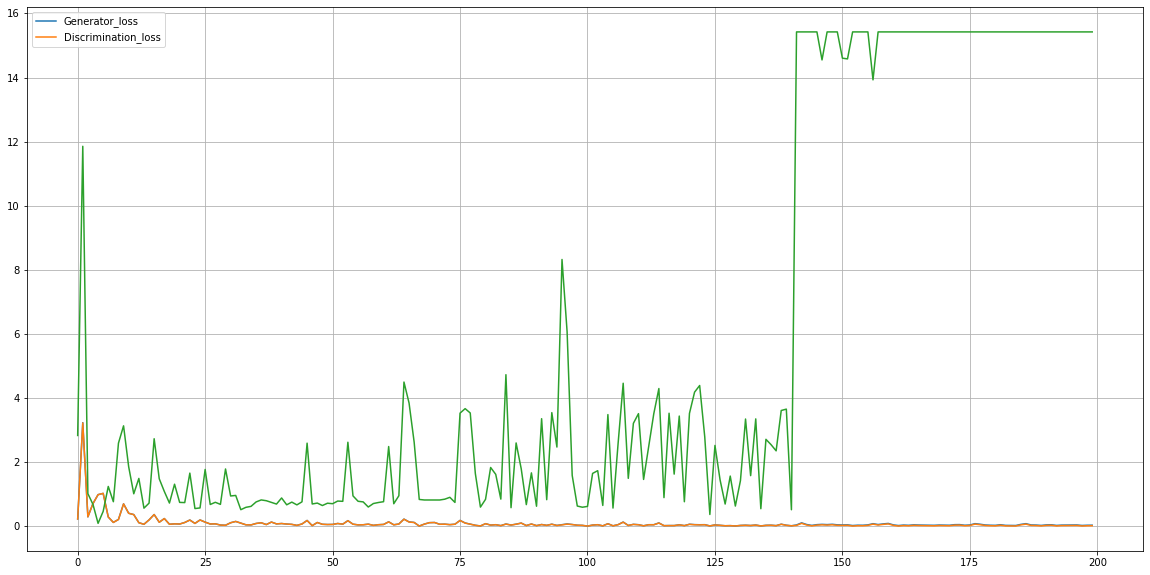

In [117]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(hist)
ax.legend(['Generator_loss', 'Discrimination_loss'])
ax.grid()

60/60 [==============================] - 1s 22ms/step


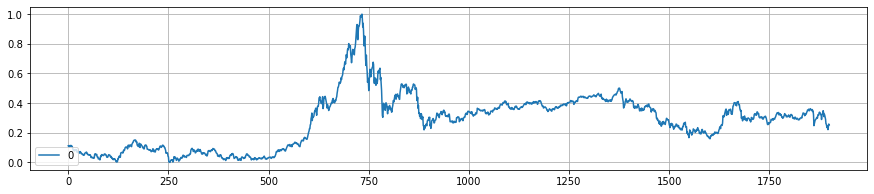

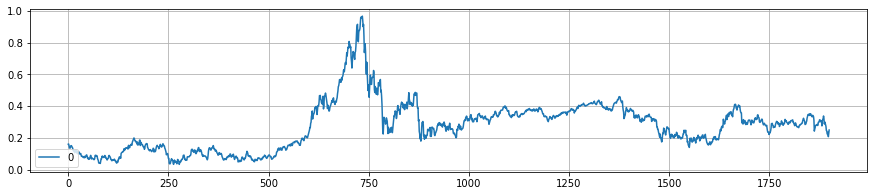

In [73]:
prediction = generator.predict(X_all)
prediction = np.reshape(prediction,(1900,1))
y =np.add(train_scaled[look_back-1:-1],prediction) 
y = np.reshape(y,(1900,1))
fig, ax = plt.subplots(1,1, figsize=[15,3])
temp = train_scaled[look_back:]
ax.plot(temp);
ax.grid()
ax.legend(range(15),loc='lower left')
fig, ax = plt.subplots(1,1, figsize=[15,3])
ax.plot(y);
ax.grid()
ax.legend(range(15),loc='lower left')

In [108]:
n = 0
ntimes = 100
ninput=1
predition_times = 5
last = X_all[n]
last = last.reshape(1,100,1)
# print(last)
X_predict = last

for i in range(predition_times):
    last_diff = generator.predict(last)
#     print("last diff:", last_diff)
#     last_new = last[:,-1]+last_diff
#     print("last new:", last_new)
    new = last[:,-1]+last_diff
    last = last[:,1:]
    last = np.append(last,new)
    X_predict = np.append(X_predict,new)
    
    
    print('=====%d====='%i)
#     pprint(last)
    last = last.reshape(1,100,1)

    
# X_predict = np.array(X_predict)
X_predict = np.reshape(X_predict,(predition_times+ntimes,ninput))

X_predict.shape

1/1 [==============================] - 0s 34ms/step
=====0=====
1/1 [==============================] - 0s 39ms/step
=====1=====
1/1 [==============================] - 0s 30ms/step
=====2=====
1/1 [==============================] - 0s 30ms/step
=====3=====
1/1 [==============================] - 0s 26ms/step
=====4=====


(105, 1)

In [109]:
X_generated = scaler2.inverse_transform(X_predict)
X_generated = X_generated.reshape(105)
X_generated.shape

(105,)

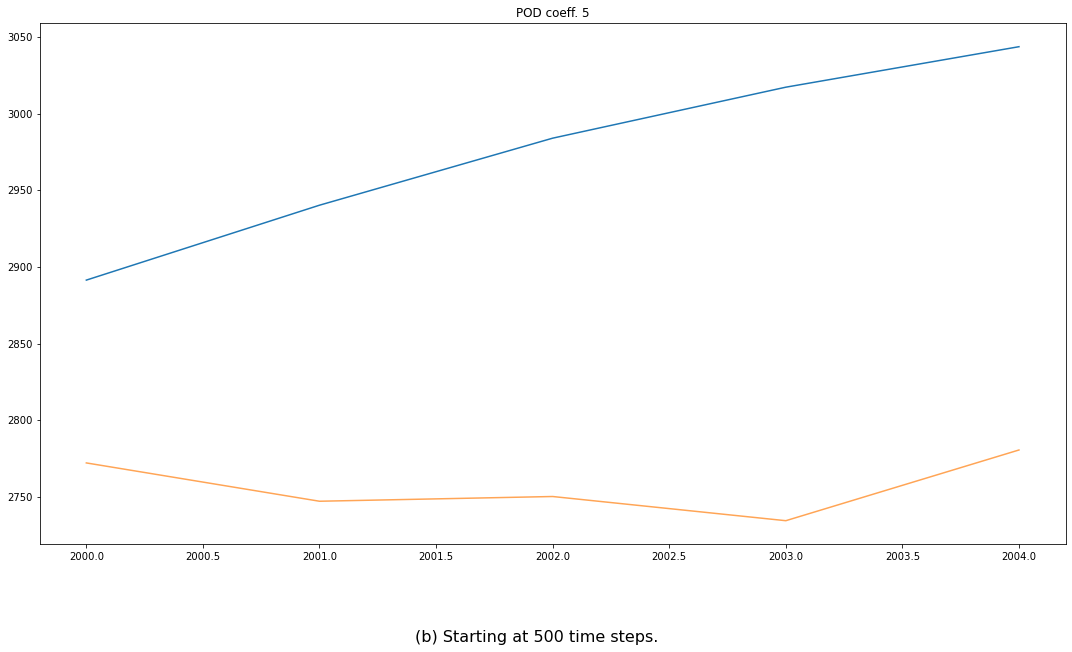

In [110]:
fig, ax = plt.subplots(1,1, figsize=[15,8])
times = np.arange(0, len(dataset), dtype="float64")
ax.set_title("POD coeff. %d"%(i+1))
#     ax.flatten()[i].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
ax.plot(times[2000:2005], X_generated[100:])
ax.plot(times[2000:2005], np.asarray( dataset[2000:2005]), alpha=0.7)
plt.tight_layout()
my_suptitle = plt.suptitle("(b) Starting at 500 time steps.", y=-0.1, fontsize=16)